In [4]:
import os
import sys
sys.path.append('../')
import io
import time
import json
import tensorflow as tf
from PIL import Image
import numpy as np
import multiprocessing
import concurrent.futures
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt

from utils.image_preprocessor import *
from TFRHelper import *

In [5]:
def create_gaussian_kernel(dot_size, num_channels):
    # make a canvas
    dot_size = dot_size * 2

    alpha = 24.0
    x_axis = tf.linspace(alpha, -alpha, dot_size)[:, None]
    y_axis = tf.linspace(alpha, -alpha, dot_size)[None, :]

    template = tf.sqrt(x_axis ** 2 + y_axis ** 2)
    template = tf.reduce_max(template) - template
    template = template / tf.reduce_max(template)

    kernel = tf.reshape([template] * num_channels, (num_channels, dot_size, dot_size, 1))
    kernel = tf.transpose(kernel, [1, 2, 0, 3])
    return kernel

def get_boundary_map_wflw(pts2d, img):

    landmarks = pts2d.tolist()

    jaw = landmarks[0:33]
    
    right_eyebrow = landmarks[33:42]
    temp = (right_eyebrow[1:5] + np.flip(right_eyebrow[5:], 0)) / 2
    right_eyebrow = right_eyebrow[0:1] + temp.tolist()
    
    left_eyebrow = landmarks[42:51]
    temp = (left_eyebrow[0:4] + np.flip(left_eyebrow[5:], 0)) / 2
    left_eyebrow = temp.tolist() + left_eyebrow[4:5]
    
    nose_vert = landmarks[51:55]
    nose_hori = landmarks[55:60]
    
    re_upper = landmarks[60:65]
    re_lower = landmarks[64:68] + landmarks[60:61]
    
    le_upper = landmarks[68:73]
    le_lower = landmarks[72:76] + landmarks[68:69]
    
    mouth_upper = landmarks[76:83]
    mouth_lower = landmarks[82:88] + landmarks[76:77]

    boundaries = [jaw,
                  right_eyebrow, left_eyebrow,
                  nose_vert, nose_hori,
                  re_upper, re_lower,
                  le_upper, le_lower,
                  mouth_upper, mouth_lower]
    h,w,c, = img.shape
    heatmap = []

    for landmark in boundaries:
        pad = 1
        pts = np.pad(landmark, [(pad,pad), (0,0)], mode='wrap')
        x, y = np.transpose(landmark)
        i = np.arange(0, len(landmark))

        interp_i = np.linspace(0, i.max(), 5 * i.size)

        xi = interp1d(i, x, kind='cubic')(interp_i)
        yi = interp1d(i, y, kind='cubic')(interp_i)

        pts = np.reshape(np.stack([xi, yi], 1), (-1, 2))
        pts = np.array(pts, np.int32)
        pts = pts.reshape((-1, 1, 2))

        temp = np.zeros((h, w))
        temp = cv2.polylines(temp, [pts], False, (200), 1)

        heatmap.append(temp)

    heatmap = np.reshape(heatmap, (len(boundaries), h, w))

    return heatmap

kernel = create_gaussian_kernel(5, 11)

In [6]:
data_path = "../../../data-archive/facial_landmarks/WFLW"

In [7]:
img_data_path = os.path.join(data_path, 'WFLW_images')
annotation_data_path = os.path.join(data_path, 'WFLW_annotations')
rect_attr, pt_test = os.listdir(annotation_data_path)

test, train, readme = os.listdir(os.path.join(annotation_data_path, rect_attr))

In [8]:
file = open(os.path.join(annotation_data_path, rect_attr, test))
temp = file.read()
file.close()

temp = temp.split('\n')[:-1]

In [9]:
i = np.random.choice(range(len(temp)))
dt = temp[i].split(' ')
img_path = os.path.join(img_data_path, dt[-1])

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

landmarks = [float(x) for x in dt[:196]]
landmarks = np.reshape(landmarks, (-1, 2))
rect = [int(x) for x in dt[196:200]]
pose, expression, illumination, makeup, occlusion, blur = [int(x) for x in dt[200:-1]]

face_bbox = get_face_roi3(img, landmarks)
face = crop_image(img, face_bbox)
landmarks = get_new_landmark(landmarks, face_bbox)

h, w, c = face.shape

normed_landmark = landmarks / [w, h]
face = cv2.resize(face, (240, 240))
temp_landmark = normed_landmark * 240

boundary_map = get_boundary_map_wflw(temp_landmark, face)
boundary_map = np.transpose(boundary_map, [1,2,0])
w, h, c = boundary_map.shape
input_tensor = np.reshape(boundary_map, (1, w, h, c))
input_tensor = tf.cast(input_tensor, np.float32)
heatmap = tf.nn.depthwise_conv2d(input_tensor, kernel,
                                 strides=[1, 1, 1, 1], padding='SAME')[0]

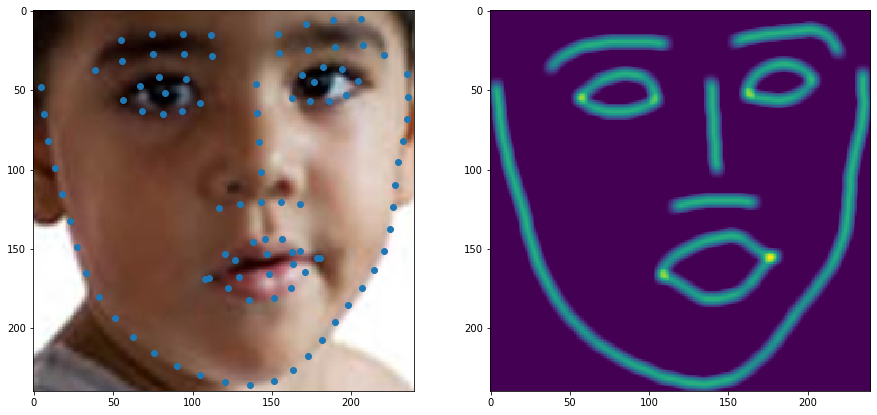

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15, 15))
x, y = np.transpose(temp_landmark)
axes[0].imshow(face)
axes[0].scatter(x, y)
axes[1].imshow(np.sum(heatmap, -1))

# to 68 landmarks

In [11]:
def get_68_landmarks(landmarks):

    jaw = landmarks[0:33:2]

    right_eyebrow = landmarks[33:42]
    temp = (right_eyebrow[1:5] + np.flip(right_eyebrow[5:], 0)) / 2
    right_eyebrow = right_eyebrow[0:1] + temp.tolist()

    left_eyebrow = landmarks[42:51]
    temp = (left_eyebrow[0:4] + np.flip(left_eyebrow[5:], 0)) / 2
    left_eyebrow = temp.tolist() + left_eyebrow[4:5]

    nose_vert = landmarks[51:55]
    nose_hori = landmarks[55:60]

    re_upper = landmarks[60:65]
    re_upper.pop(2)
    re_lower = landmarks[65:68]
    re_lower.pop(1)

    le_upper = landmarks[68:73]
    le_upper.pop(2)
    le_lower = landmarks[73:76]
    le_lower.pop(1)

    mouth_upper = landmarks[76:83]
    mouth_lower = landmarks[83:88]
    
    mouth_inner = landmarks[88:96]
    
    return jaw + right_eyebrow + left_eyebrow + nose_vert + nose_hori + re_upper + re_lower + le_upper + le_lower + mouth_upper + mouth_lower + mouth_inner

68


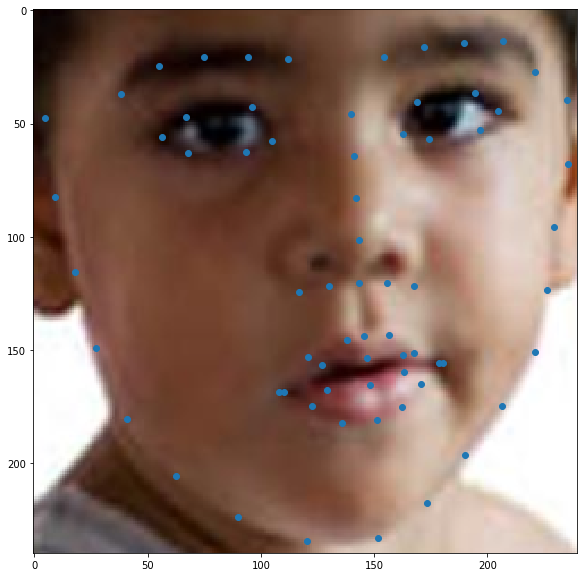

In [12]:
landmark68 = get_68_landmarks(temp_landmark.tolist())
x, y = np.transpose(landmark68)
plt.figure(figsize=(10,10))
print(len(landmark68))
plt.imshow(face)
plt.scatter(x, y)

In [13]:
def parse_data(dt):
    dt = dt.split(' ')
    img_path = os.path.join(img_data_path, dt[-1])

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    landmarks = [float(x) for x in dt[:196]]
    landmarks = np.reshape(landmarks, (-1, 2))
    rect = [int(x) for x in dt[196:200]]
    pose, expression, illumination, makeup, occlusion, blur = [int(x) for x in dt[200:-1]]

    face_bbox = get_face_roi3(img, landmarks)
    face = crop_image(img, face_bbox)
    landmarks = get_new_landmark(landmarks, face_bbox)

    h, w, c = face.shape
#     if h > w:
#         padding = (h - w) // 2
#         face = cv2.copyMakeBorder(face, 0, 0, padding, padding, cv2.BORDER_REPLICATE)
#         landmarks = landmarks + [padding, 0]

#     if w > h:
#         padding = (w - h) // 2
#         face = cv2.copyMakeBorder(face, padding, padding, 0, 0, cv2.BORDER_REPLICATE)
#         landmarks = landmarks + [0, padding]

    normed_landmark = landmarks / [w, h]
    face = cv2.resize(face, (240, 240))
    temp_landmark = normed_landmark * 240

    boundary_map = get_boundary_map_wflw(temp_landmark, face)
    boundary_map = np.transpose(boundary_map, [1,2,0])
    w, h, c = boundary_map.shape
    input_tensor = np.reshape(boundary_map, (1, w, h, c))
    input_tensor = tf.cast(input_tensor, np.float32)
    boundary_map = tf.nn.depthwise_conv2d(input_tensor, kernel,
                                     strides=[1, 1, 1, 1], padding='SAME')[0]
    
    normed_68_landmarks = get_68_landmarks(normed_landmark.tolist())
    
    return face, normed_68_landmarks, boundary_map

68


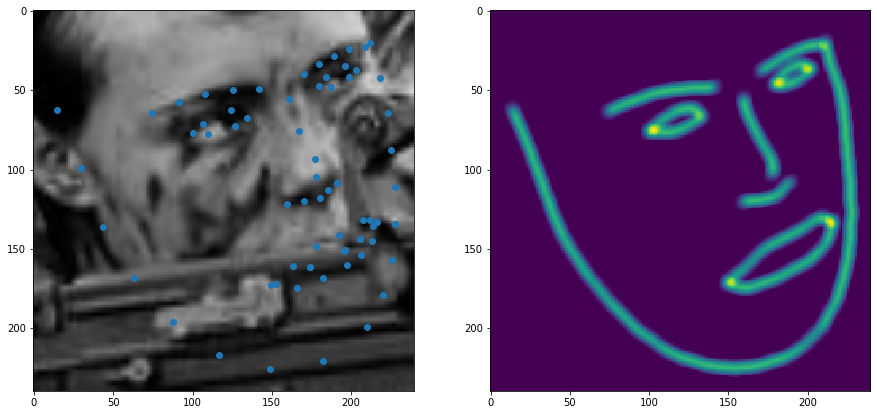

In [14]:
i = np.random.choice(range(len(temp)))
face, normed_landmark, boundary_map = parse_data(temp[i])

temp_landmark = np.array(normed_landmark) * 240
print(len(temp_landmark))

fig, axes = plt.subplots(1, 2, figsize=(15, 15))
x, y = np.transpose(temp_landmark)
axes[0].imshow(face)
axes[0].scatter(x, y)
axes[1].imshow(np.sum(boundary_map, -1))

# cvt to tfrecord

In [15]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _bytes_feature2(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=value))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))


In [16]:
write_path = '/media/gabe/bradisk_2/landmark-tfr/tight/'

img_data_path = os.path.join(data_path, 'WFLW_images')
annotation_data_path = os.path.join(data_path, 'WFLW_annotations')
rect_attr, pt_test = os.listdir(annotation_data_path)

test, train, readme = os.listdir(os.path.join(annotation_data_path, rect_attr))

In [17]:
for i, txt_file in enumerate([train, test]):
    if txt_file == train:
        fn = 'wflw_train'
        print('fn:', fn)
    else:
        fn = 'wflw_test'
        print('fn:', fn)

    file = open(os.path.join(annotation_data_path, rect_attr, txt_file))
    temp = file.read()
    file.close()

    all_data = temp.split('\n')[:-1]
    
    counter = 0
    
    print(f"Converting subject {fn} to tfrecord - {len(all_data)} files")
    tfr_path = os.path.join(write_path, f'{fn}_boundary.tfrecords')
    with tf.io.TFRecordWriter(tfr_path) as writer:
        for n in range(len(all_data)):
            features = parse_data(all_data[n])

            if features == None:
                continue
                
            face, normed_landmark, boundary_map = features

            counter = counter + 1
            
            w, h, c = boundary_map.shape
            encoded_boundaries = []
            for i in range(c):
                temp = boundary_map[:, :, i]
                temp2 = cv2.normalize(temp.numpy(), None, 0, 255, cv2.NORM_MINMAX)
                temp3 = tf.cast(temp2, tf.uint8)
                temp4 = tf.reshape(temp3, (240, 240, 1))
                encoded = tf.io.encode_jpeg(temp4, quality=100).numpy()
                encoded_boundaries.append(encoded)

            encoded_face = tf.io.encode_jpeg(face, quality=100).numpy()
            
            feature = {
                'image': _bytes_feature(encoded_face),
                'landmarks': _float_feature(np.reshape(normed_landmark, (-1)).tolist()),
                'headpose': _float_feature(np.reshape([0.0, 0.0, 0.0], (-1)).tolist()),
                'jaw': _bytes_feature(encoded_boundaries[0]),
                'right_eyebrow': _bytes_feature(encoded_boundaries[1]),
                'left_eyebrow': _bytes_feature(encoded_boundaries[2]),
                'nose_vert': _bytes_feature(encoded_boundaries[3]),
                'nose_hori': _bytes_feature(encoded_boundaries[4]),
                're_upper': _bytes_feature(encoded_boundaries[5]),
                're_lower': _bytes_feature(encoded_boundaries[6]),
                'le_upper': _bytes_feature(encoded_boundaries[7]),
                'le_lower': _bytes_feature(encoded_boundaries[8]),
                'mouth_upper': _bytes_feature(encoded_boundaries[9]),
                'mouth_lower': _bytes_feature(encoded_boundaries[10])
            }
            
            example = tf.train.Example(features=tf.train.Features(feature=feature))
            writer.write(example.SerializeToString())

    print(f"Completed {fn} - {counter} files")    

fn: wflw_train
Converting subject wflw_train to tfrecord - 7500 files
Completed wflw_train - 7500 files
fn: wflw_test
Converting subject wflw_test to tfrecord - 2500 files
Completed wflw_test - 2500 files
